---

# Proyecto 1: Hack a Boss
## Análisis del Top 10 ETFs

Proyecto de análisis del Top 10 de ETFs.

### Documentación del Proyecto

1. [Presentación Paula](https://docs.google.com/presentation/d/1Wk4tVhK89EP7b4iiIhvcTk4n5uHJkxgnuADb6Dk_Nto/edit?usp=sharing)

### Páginas datos fundamentales
1. [MorningStar](https://www.morningstar.es/es/)
2. [Dataroma](https://www.dataroma.com/m/home.php)

---





# Importación de **librerías**
### Incluid aquí las librerías a instalar e importar

In [ ]:
# Instalar las librerías
!pip install yfinance
!pip install yahooquery
!pip install airtable-python-wrapper

In [27]:
# Importar las librerías
import time
import requests
import warnings
import numpy as np
import yfinance as yf
import yahooquery as yq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from pprint import pprint
import airtable
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Sección Extracción de datos (API y WebScraping)





In [30]:
HEADERS = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

def seleccion_etf(tipo_etfs:str, num:int) -> list:
    # Obtención de los símbolos del Top ETFs de EEUU
    s = yq.Screener()
    dict_query = s.get_screeners(tipo_etfs, num)
    tickers = [symbol['symbol'] for symbol in dict_query[tipo_etfs]['quotes']]
    return tickers

def corregir_nombres_columnas(df_columns:pd.Index) -> pd.Index:
    # Eliminar caracteres especiales
    df_columns = df_columns.str.replace('[^\w\s]', '', regex=True)
    # Sustituir espacios por _
    df_columns = df_columns.str.replace(' ', '_')
    # Retornar el DF
    return(df_columns)
    
def down_price_vol(tickers:list) -> pd.DataFrame:
    '''
    Esta función descarga los cambios porcentuales de las cotizaciones
    y del volumen de negociación de la lista de símbolos en un dataframe.

    Parámetros:
    tickers (list): La lista de símbolos.

    Retorna:
    DataFrame con los incrementos porcentuales de las cotizaciones

    Ejemplo:
    >>> df_price_vol = down_price_vol(['MSFT'])
    '''
    # Descarga de las cotizaciones
    df = yf.download(tickers, period='max')
    # Obtener los nombres de las columnas para 'Adj Close' y 'Volume'
    adj_close_cols = [('Adj Close', ticker) for ticker in tickers]
    volume_cols = [('Volume', ticker) for ticker in tickers]

    # Seleccionar las columnas de interés
    df = df[adj_close_cols + volume_cols]
    # Eliminar valores nulos y cambiar los precios por incrementos porcentuales
    df = df.dropna().pct_change(1).dropna()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    # Ordenar y formatear el las columnas
    '''
    df_stack = df.stack(level=1)
    df_reset = df_stack.reset_index()
    df_final = df_reset.rename(columns={'level_0': 'Date', 'level_1': 'Ticker'})
    df_final = df_final.melt(id_vars=['Date', 'Ticker'], var_name='Attribute', value_name='Value')
    df_pivot = df_final.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='Value').reset_index()
    df_pivot.columns.name = None
    df = df_pivot.rename(columns={'Adj Close': 'Price', 'Volume': 'Volume'})
    '''
    df.columns = [f'{j}.{i}' for i, j in df.columns]
    columns = [col for etf in tickers for col in [f'{etf}.Adj Close', f'{etf}.Volume']]
    df = df[columns]
    df.columns = [col.replace('.Adj Close', '.price').replace('.Volume', '.volume') for col in df.columns]
    # Retornar DataFrame
    return(df)

def web_scraping_sectors(tickers:list) -> pd.DataFrame:
    '''
    Esta función hace web scraping a la página de Yahoo Finance
    para obtener la distribución en los sectores en los que está
    invertido el ETF

    Parámetros:
    tickers (list): La lista de símbolos.

    Retorna:
    DataFrame con los porcentajes de la distribución de sectores

    Ejemplo:
    >>> df_sectores = web_scraping_sectores()
    '''
    url_base = "https://es.finance.yahoo.com/quote/"
    lista_sectores = [
        "Materiales básicos", "Acciones cíclicas", "Servicios financieros",
        "Propiedades inmobiliarias", "Acciones defensivas", "Atención sanitaria",
        "Utilidades", "Servicios de comunicación", "Energía", "Industriales",
        "Tecnología"
    ]
    dict_sectores = {}
    for etf in tqdm(tickers):
        url = f'{url_base}{etf}/holdings?p={etf}'
        response = requests.get(
            url,
            headers = HEADERS
            )
        soup = BeautifulSoup(response.text, 'html.parser')
        sectores_etf = {}
        lista_contenedores = soup.findAll('div', class_='Bdbw(1px) Bdbc($seperatorColor) Bdbs(s) H(25px) Pt(10px)')
        for item in lista_contenedores:
            sector = item.find('span', class_='Mend(5px) Whs(nw)').text
            if sector in lista_sectores:
                valor = item.find('span', class_='W(20%) D(b) Fl(start) Ta(e)').text
                sectores_etf[sector] = valor
        dict_sectores[etf] = sectores_etf
    # Convertir diccionario en dataframe
    df = pd.DataFrame.from_dict(dict_sectores).T
    # Convertir todas las entradas a strings, eliminar el '%' y reemplazar comas por puntos
    df = df.map(lambda x: str(x).replace('%', '').replace(',', '.'))
    # Convertir las cadenas a números flotantes y dividir por 100 para tener los porcentajes en formato decimal
    df = df.map(lambda x: float(x) / 100.0 if x != 'N/A' else 0)
    # Quitar los espacios
    df.columns = corregir_nombres_columnas(df.columns)
    # Resetear índice
    df = df.reset_index()
    df = df.rename(columns={'index':'Ticker'})
    # Retornar DataFrame
    return (df)

def tabla_net_assets(tickers:list) -> pd.DataFrame:
    def convertir_valor(valor):
        if 'M' in valor:
            return float(valor.replace('M', ''))
        elif 'B' in valor:
            return float(valor.replace('B', '')) * 1000
        else:
            return float(valor)

    #Net assets table

    net_assets = pd.DataFrame()

    for ticker in tqdm(tickers):

        url = f"https://finance.yahoo.com/quote/{ticker}?p={ticker}"
        response = requests.get(url, headers=HEADERS)

        try:
            tables = pd.read_html(response.text)
            for table in tables:
                labels_to_remove = ["Previous Close", "Open", "Bid", "Ask", "Day's Range", "52 Week Range", "Volume","Avg. Volume"]
                table = table[~table.iloc[:, 0].isin(labels_to_remove)]

                data_series = pd.Series(dict(zip(table.iloc[:, 0], table.iloc[:, 1])))

                net_assets[ticker] = data_series
        except ValueError:
            print(f"No hay tablas para {ticker}")

    net_assets = net_assets.T
    # Eliminar columnas
    df = net_assets.drop(['NAV', 'PE Ratio (TTM)', 'Expense Ratio (net)'], axis=1)
    # Corregir nombres de columnas
    df.columns = corregir_nombres_columnas(df.columns)
    # Convertir todas las entradas a strings, eliminar el '%' y reemplazar comas por puntos
    df[['Yield', 'YTD_Daily_Total_Return']] = df[['Yield', 'YTD_Daily_Total_Return']].map(lambda x: str(x).replace('%', ''))
    # Convertir las cadenas a números flotantes y dividir por 100 para tener los porcentajes en formato decimal
    df[['Yield', 'YTD_Daily_Total_Return']] = df[['Yield', 'YTD_Daily_Total_Return']].map(lambda x: float(x) / 100.0)
    # Convertir la columna Beta a float
    df['Beta_5Y_Monthly'] = df['Beta_5Y_Monthly'].astype(float)
    # Convertir Inception_Date en datetime
    df['Inception_Date'] = pd.to_datetime(df['Inception_Date'], format='%Y-%m-%d')
    # Reformatear columna Net_Assets
    df['Net_Assets_Millions'] = df['Net_Assets'].apply(convertir_valor)
    df = df.drop('Net_Assets', axis=1)
    # Resetear índice
    df = df.reset_index()
    df = df.rename(columns={'index':'Ticker'})
    # Retornar df
    return(df)

def portafolio_activos_etfs(tickers:list)->pd.DataFrame:
    all_dataframes = []

    for ticker in tqdm(tickers):

        url = f"https://finance.yahoo.com/quote/{ticker}/holdings?p={ticker}"
        response = requests.get(url, headers=HEADERS)

        try:
            tables = pd.read_html(response.text)
            for table in tables:
                table['Ticker'] = ticker  # Add the 'Ticker' column
                all_dataframes.append(table)
        except ValueError:
            print(f"No tables found for {ticker}")
        break

    # Concatenate all dataframes
    df = pd.concat(all_dataframes, ignore_index=True)
    # Corregir nombres de columnas
    print(df.columns)
    df.columns = corregir_nombres_columnas(df.columns)
    df.rename(columns={"_Assets":"Assets"}, inplace=True)
    # Convertir todas las entradas a strings, eliminar el '%' y reemplazar comas por puntos
    df['Assets'] = df['Assets'].map(lambda x: str(x).replace('%', ''))
    # Convertir las cadenas a números flotantes y dividir por 100 para tener los porcentajes en formato decimal
    df['Assets'] = df['Assets'].map(lambda x: float(x) / 100.0)
    # Retornar df
    return(df)

In [18]:
# Esta línea se ha de ejecutar una sola vez
# en todo el proyecto, si se hace, es posible que
# el Top de ETFs cambie y no se correspondan con los
# almacenados en Airtable
tickers = seleccion_etf('top_etfs_us', 100)

In [ ]:
df_price_vol = down_price_vol(tickers)
df_sect_dist = web_scraping_sectors(tickers)
df_net_activos = tabla_net_assets(tickers)
df_portafolio_activos = portafolio_activos_etfs(tickers)

# Carga de datos a Airtable

In [ ]:
# Parámetros de airtable y creación del objeto airtable
base_id = 'app8fsCvHI7Tau4le'
api_key = 'patyBg6zyoW4EXNI7.205cca8c88a716fa4010850bd58995623d060734e24fa937be40f428d3bfb7fe'
# Definir tabla id con dataframe
lista_dataframes = [
    ('tbl5GKDEdJoTMXTci', df_price_vol),
    ('tblWV2ERYBOrXozth', df_sect_dist),
    ('tblvbY1n5rzmFyBqZ', df_net_activos),
    ('tblvxs74FGznyUCfL', df_portafolio_activos)
    ]

In [ ]:
for tid, df in lista_dataframes:
    df.iloc[0:1].to_csv(f'{tid}.csv', index=False) 

In [ ]:
# Bucle para subir los datos a Airtable
for tabla_id, dataframe in lista_dataframes:
    air = airtable.Airtable(base_id=base_id, table_name=tabla_id, api_key=api_key)
    for i in range(0, len(dataframe), 10):
        bloque = dataframe.iloc[i:i+10]
        registros = bloque.to_dict(orient="records")
        air.batch_insert(registros)

# Sección Funciones Estadísticas

### Identificar el sector con la mayor inversión en promedio

In [ ]:
# Dataframe con los activos netos
df_divsf_rend = df_sect_dist
df_divsf_rend['Rentabilidad'] = df_net_activos['Yield']
df_divsf_rend['Riesgo'] = df_net_activos['Beta_5Y_Monthly']
# Cálculo y selección
sector_columns = df_divsf_rend.columns[2:-3]  # Seleccionar solo las columnas de sectores
df_divsf_rend = df_divsf_rend[sector_columns].mean().sort_values(ascending=False)
# Visualización
plt.figure(figsize=(14,7))
df_divsf_rend.plot(kind='bar', color='skyblue')
plt.title('Inversión Promedio en Cada Sector')
plt.xlabel('Sectores')
plt.ylabel('Inversión Promedio (Proporción)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Determinar el umbral para los ETFs más rentables (el cuartil superior)

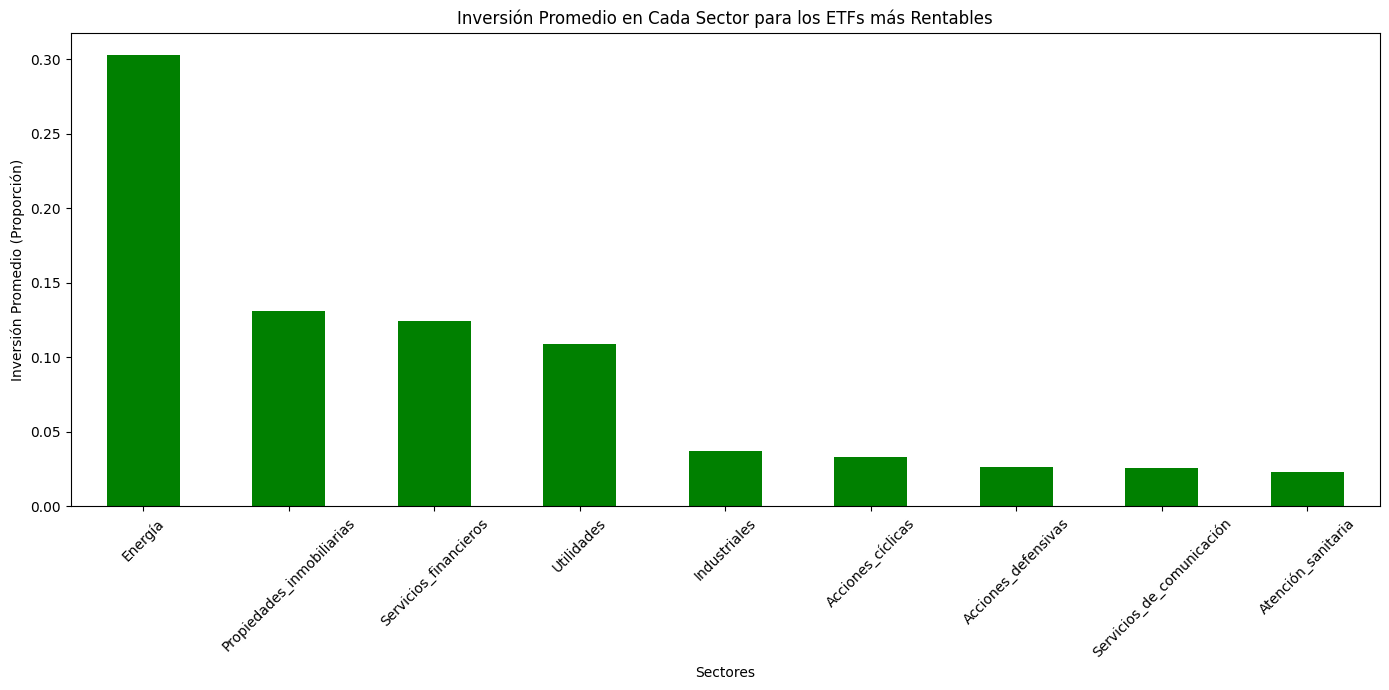

In [55]:
df_divsf_rend = df_sect_dist
threshold_rentabilidad = df_divsf_rend['Rentabilidad'].quantile(0.75)
etfs_mas_rentables = df_divsf_rend[df_divsf_rend['Rentabilidad'] >= threshold_rentabilidad]
# Calcular
df_divsf_rend = etfs_mas_rentables[sector_columns].mean().sort_values(ascending=False)
# Visualizar
plt.figure(figsize=(14,7))
df_divsf_rend.plot(kind='bar', color='green')
plt.title('Inversión Promedio en Cada Sector para los ETFs más Rentables')
plt.xlabel('Sectores')
plt.ylabel('Inversión Promedio (Proporción)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top rentabilidad-riesgo ETFs

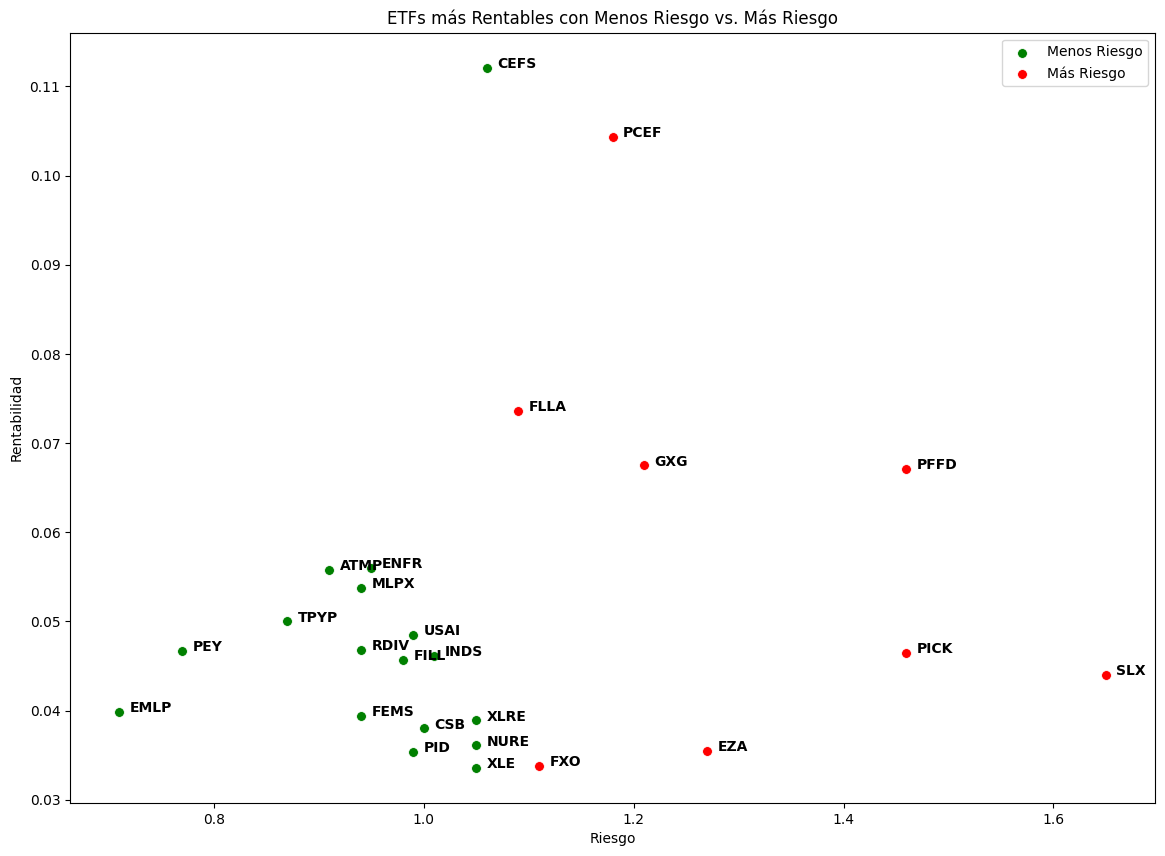

In [56]:
df_divsf_rend = df_sect_dist
# Definir umbrales de riesgo utilizando la mediana como punto de corte
median_risk = df_divsf_rend['Riesgo'].median()

# ETFs más rentables con menos riesgo
etfs_rentables_menos_riesgo = etfs_mas_rentables[etfs_mas_rentables['Riesgo'] <= median_risk]

# ETFs más rentables con más riesgo
etfs_rentables_mas_riesgo = etfs_mas_rentables[etfs_mas_rentables['Riesgo'] > median_risk]

# Identificar los ETFs específicos
# Más rentables con menos riesgo
etfs_rentables_menos_riesgo_sorted = etfs_rentables_menos_riesgo.sort_values(by=['Rentabilidad', 'Riesgo'], ascending=[False, True])

# Más rentables con más riesgo
etfs_rentables_mas_riesgo_sorted = etfs_rentables_mas_riesgo.sort_values(by=['Rentabilidad', 'Riesgo'], ascending=[False, False])

etfs_rentables_menos_riesgo_sorted[['Ticker', 'Rentabilidad', 'Riesgo']], etfs_rentables_mas_riesgo_sorted[['Ticker', 'Rentabilidad', 'Riesgo']]

# Configurar el tamaño del gráfico
plt.figure(figsize=(14,10))

# Graficar los ETFs más rentables con menos riesgo en verde
sns.scatterplot(
    data=etfs_rentables_menos_riesgo_sorted,
    x='Riesgo', 
    y='Rentabilidad', 
    color='green', 
    label='Menos Riesgo',
    s=50  # Tamaño del punto
)

# Graficar los ETFs más rentables con más riesgo en rojo
sns.scatterplot(
    data=etfs_rentables_mas_riesgo_sorted,
    x='Riesgo', 
    y='Rentabilidad', 
    color='red', 
    label='Más Riesgo',
    s=50  # Tamaño del punto
)

# Añadir anotaciones para los tickers
for line in range(0, etfs_rentables_menos_riesgo_sorted.shape[0]):
    plt.text(
        etfs_rentables_menos_riesgo_sorted['Riesgo'].iloc[line]+0.01,  # Posición en X con un pequeño offset
        etfs_rentables_menos_riesgo_sorted['Rentabilidad'].iloc[line],  # Posición en Y
        etfs_rentables_menos_riesgo_sorted['Ticker'].iloc[line],  # Texto de la anotación
        horizontalalignment='left',
        size='medium',
        color='black',
        weight='semibold'
    )

for line in range(0, etfs_rentables_mas_riesgo_sorted.shape[0]):
    plt.text(
        etfs_rentables_mas_riesgo_sorted['Riesgo'].iloc[line]+0.01,  # Posición en X con un pequeño offset
        etfs_rentables_mas_riesgo_sorted['Rentabilidad'].iloc[line],  # Posición en Y
        etfs_rentables_mas_riesgo_sorted['Ticker'].iloc[line],  # Texto de la anotación
        horizontalalignment='left',
        size='medium',
        color='black',
        weight='semibold'
    )

# Título y etiquetas
plt.title('ETFs más Rentables con Menos Riesgo vs. Más Riesgo')
plt.xlabel('Riesgo')
plt.ylabel('Rentabilidad')
plt.legend()

# Mostrar el gráfico
plt.show()

# Sección Josep

In [ ]:
df


In [ ]:
df_describe = df.describe()
df_describe
